In [59]:
import torch
from torchinfo import summary
import torch.nn as nn
import torch.nn.functional as F

# Understanding Deep Learning 12.1 - 12.3

In the first part of this notebook we'll build a self-attention mechanism as described in Section 12.1.  

To build the self-attention mechanism or network we'll need to do some linear algebra.  Let's remind ourselves how that works in PyTorch and also see how it connects to the familiar `nn.Linear` layer we've been using for our networks.

The inputs to our network will be a sequence of $3$ vectors each of length $4$.   We'll start with three vectors of ones, each in $\mathbb{R}^{4}$.  Then we'll multiply by a diagonal $4 \times 4$ matrix and add a vector of twos. Notice that the multiplication will be on the right to get the dimensions to match.   Broadcasting will help here too!

In [38]:
x = torch.ones( (3,4) ).float() # 3 4D inputs in 3x4 array
A = torch.diag(torch.tensor([10.,20,30,40])) # diag 4x4 matrix
b = 2.*torch.ones( 4 ) # 4D vector

print('The input vectors:')
print(x)
print('\n')

print('The matrix A: ')
print(A)
print('\n')

print('The vector b: ')
print(b)
print('\n')

The input vectors:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])


The matrix A: 
tensor([[10.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.],
        [ 0.,  0., 30.,  0.],
        [ 0.,  0.,  0., 40.]])


The vector b: 
tensor([2., 2., 2., 2.])




Now we want to multiply each row of $\mathbf{x}$ by $A$ (on the right) and add $\mathbf{b}$ to each row.  Matrix multiplication and broadcasting make quick work of this:  

In [36]:
y = torch.matmul(x, A) + b
y

tensor([[12., 22., 32., 42.],
        [12., 22., 32., 42.],
        [12., 22., 32., 42.]])

Alternately, you can use 

In [37]:
y = x @ A + b
y

tensor([[12., 22., 32., 42.],
        [12., 22., 32., 42.],
        [12., 22., 32., 42.]])

Fortunately, PyTorch already knows how to do this with one line: `nn.Linear`.  We want to multiply each 4D input by a weights matrix and add biases.  Let's verify that the linear layer already does this:

In [41]:
import torch.nn as nn

linear_layer = nn.Linear(4,4) # four inputs and four outputs

# since we want particular weights and biases we need to set them
linear_layer.weight.data = A
linear_layer.bias.data = b

# output
output = linear_layer(x).detach() # we don't the gradient here
output

tensor([[12., 22., 32., 42.],
        [12., 22., 32., 42.],
        [12., 22., 32., 42.]])

The point here is that the matrix and vector operations that the UDL author uses are nothing more than linear layers in PyTorch.  We want to implement the Transformer Self-Attention Block in Figure 12.4 as a network.

![TransformerBlockSA](TransformerBlockSA.png)

## Implementing a Self-Attention Block in PyTorch

Let's implement this one bit at a time.  We're going to store out input sequence in a tensor with $N$ rows and $D$ columns because the linear layers will work on the last dimension of the tensor.  So we'll have to switch some things to get the dimensions right.

In [66]:
N = 3 # sequence length
D = 4 # embedding dimension

torch.manual_seed(42)

x_in = torch.randn( (N,D) ) # random sequence of N embedded vectors

query = nn.Linear(D,D)
key = nn.Linear(D,D)
value = nn.Linear(D,D)

Q = query(x_in)
K = key(x_in)
V = value(x_in)

x_in.shape, Q.shape, K.shape, V.shape

(torch.Size([3, 4]),
 torch.Size([3, 4]),
 torch.Size([3, 4]),
 torch.Size([3, 4]))

In [67]:
# raw attention scores before softmax will be Q*K^T, should be NxN
attention_scores = torch.matmul( Q, K.transpose(-2,-1) )
attention_scores.shape

torch.Size([3, 3])

In [68]:
# make attention scores in each row sum to 1
attention_weights = F.softmax(attention_scores, -1)
attention_weights

tensor([[0.2327, 0.5203, 0.2470],
        [0.5097, 0.1544, 0.3359],
        [0.2023, 0.5748, 0.2229]], grad_fn=<SoftmaxBackward0>)

In [69]:
# now use the attention weights to combine the values
x_out = torch.matmul( attention_weights, V)
x_out.shape

torch.Size([3, 4])

In [72]:
# complete this network and add comments to the right of each entry in the forward layer showing the shape of the result
class SelfAttention(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.query = nn.Linear(D,D)
        self.key = nn.Linear(D,D)
        self.value = nn.Linear(D,D)
    def forward(self, x): # x is (B,N,D)

        # Compute queries, keys, and values
        Q = self.query(x) # Q is (B,N,D)
        K = self.key(x) # K is (B,N,D)
        V = self.value(x) # V is (B,N,D)
        
        # Calculate the dot product for the queries and keys
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) # (B,N,N)
        
        # Apply softmax to get the attention weights
        attention_weights = F.softmax(attention_scores, dim=-1) # (B,N,N)
        
        # Multiply the attention weights with the values
        output = torch.matmul(attention_weights, V)  # (B,N,D)
        
        return output

In [74]:
# when you're done, execute this cell

N = 3 # length of sequence
D = 4 # embedding dimension
B = 5 # batch size

torch.manual_seed(0)
x_in = torch.randn( (B,N,D) )
SAnet = SelfAttention(D)
x_out = SAnet(x_in)
x_out

tensor([[[-0.5802, -0.2236,  0.4476, -0.3406],
         [-0.6556, -0.2515,  0.3504, -0.5715],
         [-0.4327, -0.1851,  0.6796,  0.1130]],

        [[-0.2441, -0.0572,  0.0042, -0.2378],
         [-0.2170,  0.1359,  0.2213,  0.2678],
         [-0.1303, -0.0060,  0.8015,  0.7602]],

        [[-0.3911,  0.0424,  0.0535, -0.2658],
         [-0.4593, -0.0586, -0.4128, -0.7885],
         [-0.4338, -0.0112, -0.2227, -0.5630]],

        [[-0.3300, -0.0249, -0.0857, -0.4840],
         [-0.3369, -0.0360, -0.1108, -0.5271],
         [-0.3485, -0.0512, -0.1397, -0.5974]],

        [[-0.0044, -0.1048,  0.2070, -0.0969],
         [-0.0099, -0.1151,  0.2835, -0.0504],
         [-0.0595, -0.1700,  0.5431,  0.0557]]], grad_fn=<UnsafeViewBackward0>)

## Multi-head Self Attention

![TwoHeadSA](TransformerBlockSAMultiHead.png)

Now we'll show how to build a two-headed self attention block.  

1. Split the input embedding dimension into two parts for each head.
2. Apply self-attention separately to each part.
3. Concatenate the outputs of each head.
4. Optionally add a linear layer to transform the concatenated output back to the original embedding dimension (this step is often used to mix information between the heads).

Note, the embedding dimension should be evenly divisible by the number of heads.

In [75]:
class TwoHeadSelfAttention(nn.Module):
    def __init__(self, D):
        super().__init__()
        assert D % 2 == 0, "Embedding dimension must be divisible by number of heads"
        
        # Define separate attention mechanisms for each head
        self.attention1 = SelfAttention(D//2)
        self.attention2 = SelfAttention(D//2)

        # Linear layer to project the concatenated outputs back to the original embedding dimension
        self.output_linear = nn.Linear(D, D)
        
    def forward(self, x):
        B, N, _ = x.shape
        
        # Split the embedding dimension
        x1 = x[:,:,:(D//2)] #(B,N,D/2)
        x2 = x[:,:,(D//2):] #(B,N,D/2)
        
        # Apply self-attention to each head
        output1 = self.attention1(x1) #(B,N,D/2)
        output2 = self.attention2(x2) #(B,N,D/2)
        
        # Concatenate the outputs of each head along the last dimension
        concatenated = torch.cat( [output1, output2], dim=-1)  #(B,N,D)
        
        # Optionally apply a final linear layer to mix the output from the two heads
        output = self.output_linear(concatenated) # (B,N,D)
        
        return output

In [76]:
# when you're done, execute this cell

N = 3 # length of sequence
D = 4 # embedding dimension
B = 5 # batch size

torch.manual_seed(0)
x_in = torch.randn( (B,N,D) )
SAnet2 = TwoHeadSelfAttention(D)
x_out = SAnet2(x_in)
x_out

tensor([[[-0.4729, -0.4518,  0.0934, -0.3797],
         [-0.5432, -0.4569,  0.1750, -0.3198],
         [-0.3447, -0.4362, -0.0054, -0.4252]],

        [[-0.5344, -0.4337,  0.2937, -0.1298],
         [-1.0500, -0.5401,  0.4192, -0.2939],
         [-1.0893, -0.5505,  0.4331, -0.3201]],

        [[-0.3424, -0.4303,  0.1662, -0.3551],
         [-0.2513, -0.4067,  0.1366, -0.3051],
         [-0.2875, -0.4178,  0.1491, -0.3246]],

        [[-0.2072, -0.3949,  0.1259, -0.2471],
         [-0.2117, -0.3955,  0.1413, -0.2274],
         [-0.1837, -0.3899,  0.1290, -0.2263]],

        [[-0.3074, -0.3663, -0.0207, -0.0752],
         [-0.3814, -0.3775,  0.0169, -0.0571],
         [-0.7792, -0.4435,  0.2895,  0.0525]]], grad_fn=<ViewBackward0>)

## Multi Head



**Why are multiple heads better than one?**

1. **Diverse Representation Learning**: Each head focuses on different aspects of the input, allowing parallel processing and attention to various parts of the sequence.
2. **Increased Model Capacity**: Multiple heads enrich the model's ability to represent complex dependencies without a proportional increase in parameters.
3. **Robustness to Input Variations**: The model becomes more adaptive to variations and noise in the input, as different heads can capture various features.
4. **Improved Generalization**: By integrating multiple insights, the model generalizes better across different data relationships.
5. **Redundancy and Error Correction**: Multiple heads provide redundancy, helping to correct errors and compensate for less effective individual representations.

**If each head uses only some of the dimensions of the embeddings how can multi-head attention work better than using only one head?**

1. **Specialization**: Each head specializes in different features, capturing diverse aspects of the input.
2. **Comprehensive Coverage**: Combining outputs from all heads provides a more holistic understanding.
3. **Reduced Interference**: Less overlap between heads leads to more stable learning and less noise.
4. **Efficiency**: Processing reduced dimensionality per head speeds up computation.
5. **Robust and Redundant Representations**: Ensemble of heads compensates for potential misrepresentations by individual heads.

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=2):
        super(MultiHeadSelfAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Define separate attention mechanisms for each head
        self.attentions = nn.ModuleList([
            SelfAttention(self.head_dim) for _ in range(num_heads)
        ])
        
        # Linear layer to project the concatenated outputs back to the original embedding dimension
        self.output_linear = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Split the embedding dimension
        x = x.view(batch_size, seq_len, self.num_heads, self.head_dim)
        x = x.transpose(1, 2)  # shape: (batch_size, num_heads, seq_len, head_dim)
        
        # Apply self-attention to each head
        attention_outputs = [attention(x[:, i]) for i, attention in enumerate(self.attentions)]
        
        # Concatenate the outputs of each head along the last dimension
        concatenated = torch.cat(attention_outputs, dim=-1)  # shape: (batch_size, seq_len, embed_dim)
        
        # Optionally apply a final linear layer
        output = self.output_linear(concatenated)
        
        return output

class SelfAttention(nn.Module):
    def __init__(self, head_dim):
        super(SelfAttention, self).__init__()
        self.head_dim = head_dim
        
        # Define the linear layers for Q, K, V
        self.query = nn.Linear(head_dim, head_dim)
        self.key = nn.Linear(head_dim, head_dim)
        self.value = nn.Linear(head_dim, head_dim)
        
    def forward(self, x):
        # Calculate Q, K, V
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        
        # Attention mechanism
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        weights = F.softmax(scores, dim=-1)
        output = torch.matmul(weights, V)
        
        return output

# Example usage
batch_size, seq_len, embed_dim = 2, 5, 64
num_heads = 8
x = torch.rand(batch_size, seq_len, embed_dim)  # Random input tensor
multi_head_attention = MultiHeadSelfAttention(embed_dim, num_heads = num_heads)
output = multi_head_attention(x)
print(output.shape)  # Should be (batch_size, seq_len, embed_dim)


torch.Size([2, 5, 64])


## Positional Encoding

You may have noticed that we're not using an important bit of information here with our embedding vectors.  The output of our attention networks is the same no matter where a particular embedding vector occurs in our sequence.  That's not very helpful if we're trying to get our models to learn about relationships between different elements of a sequence.  

To get around this we add a positional encoding matrix to the initial matrix of embedding vectors.  Each vector in the positional encoding matrix has the same length as an embedding vector.   Sines and cosines at different frequencies are used to generate a unique vector for each position in the sequence.  We won't study the details closely, but the positional encoding matrices are really cool to look at.  

I grabbed the code below from https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/.  We're going to visualize a positional encoding matrix for a sequence of 100 vectors each with embedding dimension 512.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
 
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P
 
P = getPositionEncoding(seq_len=10, d=4, n=100)
print(P)

[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.09983342  0.99500417]
 [ 0.90929743 -0.41614684  0.19866933  0.98006658]
 [ 0.14112001 -0.9899925   0.29552021  0.95533649]
 [-0.7568025  -0.65364362  0.38941834  0.92106099]
 [-0.95892427  0.28366219  0.47942554  0.87758256]
 [-0.2794155   0.96017029  0.56464247  0.82533561]
 [ 0.6569866   0.75390225  0.64421769  0.76484219]
 [ 0.98935825 -0.14550003  0.71735609  0.69670671]
 [ 0.41211849 -0.91113026  0.78332691  0.62160997]]


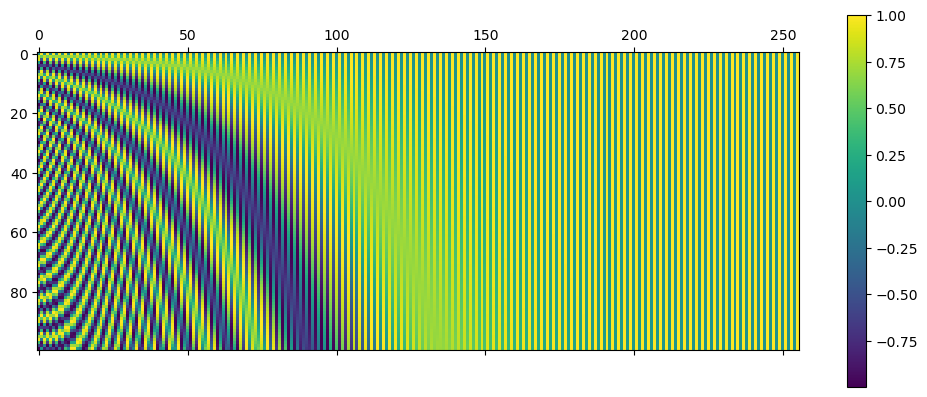

In [2]:
P = getPositionEncoding(seq_len=100, d=256, n=10000)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

In [84]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        
        # Adding an extra dimension for batch size, which is needed for addition to the input embeddings
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        # x: (batch_size, seq_len, embed_dim)
        return x + self.encoding[:, :x.size(1)]

# Example of integration with MultiHeadSelfAttention
class TransformerLayer(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(TransformerLayer, self).__init__()
        self.multi_head_attention = MultiHeadSelfAttention(embed_dim, num_heads)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.positional_encoding(x)
        x = self.multi_head_attention(x)
        x = self.layer_norm(x)
        return x

# Example usage
batch_size, seq_len, embed_dim = 2, 5, 64
x = torch.rand(batch_size, seq_len, embed_dim)  # Random input tensor
transformer_layer = TransformerLayer(embed_dim, num_heads=2)
output = transformer_layer(x)
print(output.shape)  # Should be (batch_size, seq_len, embed_dim)


torch.Size([2, 5, 64])


Absolutely! Let's create a simple transformer model to solve a basic sequence-to-sequence translation task. A common educational example is to translate short sequences of numbers into their English word equivalents (e.g., "123" to "one two three"). This task is simple enough to understand and implement but rich enough to illustrate key concepts in transformers.

### Problem Description
Translate sequences of digits (0-9) into their corresponding words. For simplicity, we'll consider sequences of three digits. This way, we can focus on understanding the model rather than dealing with complex data preprocessing or vocabulary issues.

### Steps
1. **Data Generation**: We'll create a dataset of random sequences of three digits and their corresponding word translations.
2. **Model Construction**: We'll build a simple transformer model using PyTorch.
3. **Training**: We'll train the model on the generated data.
4. **Evaluation**: We'll test the model's performance on unseen data.

### Step 1: Data Generation
First, we need to generate a dataset:

```python
import random

digits = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
def generate_data(num_samples):
    inputs = []
    outputs = []
    for _ in range(num_samples):
        sequence = [random.randint(0, 9) for _ in range(3)]
        input_str = " ".join(str(num) for num in sequence)
        output_str = " ".join(digits[num] for num in sequence)
        inputs.append(input_str)
        outputs.append(output_str)
    return inputs, outputs

train_inputs, train_outputs = generate_data(1000)
test_inputs, test_outputs = generate_data(100)

print(train_inputs[:5], train_outputs[:5])
```

### Step 2: Model Construction
We'll use the transformer architecture for this:

```python
import torch
import torch.nn as nn
from torch.nn import Transformer
import torch.optim as optim

class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_tokens, dim_model=512, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=2048):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=dim_model, nhead=nhead, 
                                       num_encoder_layers=num_encoder_layers, 
                                       num_decoder_layers=num_decoder_layers, 
                                       dim_feedforward=dim_feedforward)
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.fc_out = nn.Linear(dim_model, num_tokens)
        
    def forward(self, src, tgt):
        src = self.embedding(src)
        tgt = self.embedding(tgt)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)
        output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        output = self.fc_out(output)
        return output
```

### Step 3: Training the Model
We'll set up a training loop to optimize the model:

```python
# Assume you have functions to convert strings to tensors and vice versa, and set up training details
# This includes tokenization, DataLoader setup, loss function, and optimizer.

# Training loop (simplified)
for epoch in range(num_epochs):
    model.train()
    for src, tgt in dataloader:
        optimizer.zero_grad()
        output = model(src, tgt[:-1])
        loss = criterion(output.view(-1, output.size(-1)), tgt[1:].view(-1))
        loss.backward()
        optimizer.step()
```

### Step 4: Evaluation
Finally, we can evaluate our trained model on the test set:

```python
model.eval()
with torch.no_grad():
    correct = 0
    for src, tgt in test_dataloader:
        output = model(src, tgt[:-1])
        # Compare output to target, calculate accuracy
```

This approach uses random data to illustrate the basic functionality of transformers in a controlled setting. For a real implementation, especially in an educational environment, ensure you have detailed explanations of each part, from tokenization and data handling to the specifics of transformer architecture and the training loop. This will help students understand not just how to build a transformer but also how it processes data and learns relationships within it.

Certainly! Building a Transformer model from scratch is a great way to deeply understand the mechanics of its architecture. I'll guide you through creating a simple Transformer for the sequence-to-sequence translation task we discussed: translating sequences of digits into their word equivalents.

### Components of a Transformer

1. **Multi-Head Self-Attention**
2. **Positional Encoding**
3. **Feed-Forward Neural Network**
4. **Layer Normalization**
5. **Encoder and Decoder Layers**

I'll break down these components and show you how to implement each from scratch using PyTorch.

### Step 1: Multi-Head Self-Attention

This component is crucial for allowing the model to focus on different parts of the input sequence independently.

```python
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split embedding into self.heads pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        # Multiplication
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out
```

### Step 2: Positional Encoding

Positional encodings are added to the input embeddings to give the model information about the relative or absolute positions of the tokens in the sequence.

```python
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))

        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)]
```

### Step 3: Feed-Forward Network

This is a simple fully connected neural network applied to each position separately and identically.

```python
class FeedForward(nn.Module):
    def __init__(self, embed_size, ff_hidden_size):
        super(FeedForward, self).__init__()
        self.layer1 = nn.Linear(embed_size, ff_hidden_size)
        self.layer2 = nn.Linear(ff_hidden_size, embed_size)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x
```

### Step 4: Encoder and Decoder Layers

These are composed of self-attention layers, feed-forward networks, and normalization layers.

```python
class EncoderLayer(nn.Module):
    def __init__(self, embed_size, heads, ff_hidden_size):
        super(EncoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.attention = SelfAttention(embed_size, heads)
        self.feed_forward = FeedForward(embed_size, ff_hidden_size)

    def forward(self

, x, mask):
        attention = self.attention(x, x, x, mask)
        x = self.norm1(attention + x)
        forward = self.feed_forward(x)
        x = self.norm2(forward + x)
        return x
```

### Step 5: Build the Complete Model

Finally, you can construct the complete Transformer model using the components defined above. You would typically include a sequence of encoder and decoder layers, embed the input tokens before feeding them into the encoders, and apply the positional encodings.

This structure allows you to explain to your class the flow of data through a Transformer and the role of each component in processing and transforming the input into the output.

Building on the earlier components, we'll now construct the Decoder layer for the Transformer model, which involves additional components like masked self-attention and encoder-decoder attention. This is followed by constructing a complete Transformer model using both the Encoder and Decoder layers.

### Step 1: Decoder Layer

The Decoder layer in the Transformer model has three main components:
1. **Masked Self-Attention**: Prevents positions from attending to subsequent positions. This is critical during training to maintain the auto-regressive property.
2. **Encoder-Decoder Attention**: Allows the decoder to focus on relevant parts of the input sequence.
3. **Feed-Forward Neural Network**: The same as used in the encoder.

```python
class DecoderLayer(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion):
        super(DecoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.norm3 = nn.LayerNorm(embed_size)
        self.attention1 = SelfAttention(embed_size, heads)
        self.attention2 = SelfAttention(embed_size, heads)
        self.feed_forward = FeedForward(embed_size, forward_expansion)

    def forward(self, x, value, key, src_mask, trg_mask):
        # Masked self-attention (trg_mask is used here)
        attn1 = self.attention1(x, x, x, trg_mask)
        x = self.norm1(attn1 + x)
        # Encoder-Decoder attention (src_mask is used here)
        attn2 = self.attention2(x, value, key, src_mask)
        x = self.norm2(attn2 + x)
        # Feed Forward
        forward = self.feed_forward(x)
        x = self.norm3(forward + x)
        return x
```

### Step 2: Complete Transformer Model

Now, let's put everything together to form a complete Transformer model that includes both the encoder and decoder stacks. The model will also handle embeddings and positional encodings for both the input and output sequences.

```python
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, embed_size=256, num_layers=6, forward_expansion=512, heads=8, dropout=0.1, max_len=100):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_len)
        self.decoder = Decoder(trg_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_len)
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).type(torch.BoolTensor)
        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, enc_src, src_mask, trg_mask)
        return out

class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_len):
        super(Encoder, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(embed_size, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(embed_size, heads, forward_expansion) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        x = self.dropout(self.position_embedding(self.word_embedding(x)))
        for layer in self.layers:
            x = layer(x, mask)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_len):
        super(Decoder, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(embed_size, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(embed_size, heads, forward_expansion) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        x = self.dropout

(self.position_embedding(self.word_embedding(x)))
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)
        return x
```

### Explanation:

1. **Complete Model**: Combines encoder and decoder components, each using a series of layers.
2. **Masks**: Source mask is for ignoring padding in the input sequence, and target mask is for ensuring that positions only attend to earlier positions (maintaining auto-regression).
3. **Positional Encodings**: Added to input embeddings in both encoder and decoder to retain positional information.

This model architecture encapsulates the full Transformer model and can be used for training and inference on sequence-to-sequence tasks like translation. Note that for actual training, you would need to setup the training loop, data loading, and possibly more detailed configurations like learning rate schedules and advanced optimizer setups (e.g., using Adam with learning rate warmup).

### Layer Normalization vs. Batch Normalization

**Layer Normalization (LayerNorm)** and **Batch Normalization (BatchNorm)** are two techniques used to stabilize the learning process in deep neural networks by normalizing the input layer by layer or batch by batch, respectively. Despite their similar goals, they are applied differently and are suited to different types of data and architectures.

#### Batch Normalization (BatchNorm)
BatchNorm normalizes the activations of a previous layer for each batch. It computes the mean and variance for the entire mini-batch and uses these values to normalize the batch. Then it applies a scale and shift to these values, which are learned during training.

- **Advantages**: Helps in faster convergence; can be beneficial with internal covariate shift (when the distribution of network activations varies during training).
- **Disadvantages**: Its performance heavily depends on the size of the batch. It may not work well with small batch sizes, and it can behave inconsistently during training vs. inference due to the difference in computed statistics.

#### Layer Normalization (LayerNorm)
LayerNorm, on the other hand, normalizes the inputs across the features instead of the batch dimension. For each individual data point in a batch, it computes the mean and variance used for normalization across the features. This is particularly useful in recurrent neural networks and Transformer models where the batch size can be dynamic.

- **Advantages**: Does not depend on the batch size, making it suitable for tasks with a variable batch size and for models like RNNs and Transformers. Consistent behavior across training and inference.
- **Disadvantages**: May not leverage batch-wise information, which can be useful in certain architectures and tasks.

#### Practical Example: Layer Normalization in PyTorch

Here’s how you might implement LayerNorm in a PyTorch model. Suppose you're building a simple feed-forward neural network for illustration:

```python
import torch
import torch.nn as nn

class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.layernorm = nn.LayerNorm(hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)  # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.layernorm(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Example usage
model = FeedForwardNN(input_dim=10, hidden_dim=50)
input_tensor = torch.randn(5, 10)  # 5 data points with 10 features each
output = model(input_tensor)
print(output)
```

In this example, `LayerNorm` is applied to the output of the first linear layer (`fc1`). It normalizes the data across the 50 features of each data point independently, ensuring that the scale of outputs is controlled, which aids in stabilizing the training process.

This example shows that LayerNorm is simple to integrate into neural network architectures and especially powerful in settings where the batch size is small or varies, making BatchNorm less effective.